### Deep Solar data analysis

As part of an exercise in the Data Science Nano-Degree by Udacity, this notebook will perform **my** analysis on the [deep solar dataset](https://www.kaggle.com/tunguz/deep-solar-dataset/home).
A full description of the way the database was generated and its full analysis can be found [here](https://www.cell.com/joule/pdfExtended/S2542-4351(18)30570-1).

The above article represents a full scope analysis, I'll make a shorter intro:
Deep Solar is a project for mapping solar panel installations across the USA with high geographical resolution via sattelite images. 
The authors work had 2 stages:
1. Development of a Deep Learning network to automatically identify solar panels in satellite image tiles. 
2. Merging the results of areas where solar panels were found with data from other databases, thus, creating the dataset I'll be analyzing which allows to relate the solar panels installations with various demographical, financial and environmental factors. 

Due to the nature of the course and my **limited resources** (mainly, time) I perform a similar analysis to the one done in the article, according to the CRISP-DM principles (CRoss-Industry Process for Data Mining) **but in a smaller scale**. 

### Business Understanding 
I present 3 key business question for the data analysis: 
1. Identifying socioeconomic factors correlating with **RESIDENTIAL** solar deployment density.
2. A key question for utility companies (especially, electricity suppliers) is the estimation of power generated by consumers and being fed back into the network. I attempt to predict the **AREA** of solar panels according to data markers. By predicting the area, an estimate of that power generation can be made. 
3. Can the solar panel data help boost the quality of inference of socio-economic parameters?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import seaborn as sns
from DeepSolar_Utils import MyScatterPlot, CalcSolarDensityVsMeanOfColumn, RandomForestRegressorWithKFold
%matplotlib notebook

c:\apps\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load the modified data 
df = pd.read_csv('deepsolar_tract_modified.csv', sep=',')
pd.set_option("display.max_columns", int(np.round(df.shape[1] * 0.1)))  # When displaying, show 10% of columns

In [3]:
# Original data has too many columns for an "exercise". I chose the ones I think matter the most
# For the interpertation of the columns, see the "features.txt" file which I painstakingly arranged...   
target_features = ['tile_count', 'tile_count_residential', 'total_panel_area_residential',
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                   'solar_system_count_residential', 'solar_system_count_nonresidential',
                   'number_of_solar_system_per_household', 'number_of_years_of_education',
                   'diversity', 'average_household_income', 'county', 'employed', 'gini_index',
                   'land_area', 'per_capita_income', 'population', 'population_density',
                   'state', 'total_area', 'water_area', 'employ_rate', 'poverty_family_below_poverty_level_rate',
                   'heating_fuel_solar_rate', 'median_household_income', 'household_count',
                   'average_household_size', 'housing_unit_count', 'housing_unit_occupied_count',
                   'housing_unit_median_value', 'housing_unit_median_gross_rent', 'age_18_24_rate',
                   'age_25_34_rate', 'age_more_than_85_rate', 'age_75_84_rate', 'age_35_44_rate', 'age_45_54_rate',
                   'age_65_74_rate', 'age_55_64_rate', 'age_10_14_rate', 'age_15_17_rate', 'age_5_9_rate',
                   'household_type_family_rate', 'dropout_16_19_inschool_rate', 'mortgage_with_rate',
                   'occupancy_vacant_rate', 'occupancy_owner_rate', 'age_median', 'travel_time_average',
                   'health_insurance_public_rate', 'health_insurance_none_rate', 'daily_solar_radiation',
                   'net_metering', 'feedin_tariff', 'cooperate_tax', 'property_tax', 'sales_tax', 'rebate',
                   'avg_electricity_retail_rate']

# Size of data
df = df[target_features]
print('Original table shape is %d rows over %d columns' % (df.shape[0], df.shape[1]))

Original table shape is 72537 rows over 59 columns


In [4]:
# I'm interested in the residential area (ONLY) with deployed solar systems, so I filter the table
df = df.loc[df['tile_count_residential'] > 0]
print('table of tiles with detected residential solar panels shape is %d rows over %d columns' % (df.shape[0], df.shape[1]))

table of tiles with detected residential solar panels shape is 53529 rows over 59 columns


In [5]:
# Let's take a look at the data and some descriptive statistics
df.head()

,tile_count,tile_count_residential,total_panel_area_residential,solar_panel_area_divided_by_area,solar_panel_area_per_capita,solar_system_count_residential,solar_system_count_nonresidential,number_of_solar_system_per_household,...,daily_solar_radiation,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
1,25.0,17.0,297.274652,17.801218,0.037067,15.0,6.0,0.006726,...,NaN,34,0,0,25,12,0,9.46
2,3.0,3.0,64.505776,1.640095,0.009253,3.0,0.0,0.001112,...,3.76,34,0,0,25,12,0,9.46
4,5.0,4.0,61.050581,1.368842,0.011598,4.0,1.0,0.002087,...,3.76,34,0,0,25,12,0,9.46
6,2.0,2.0,25.299013,49.002875,0.007220,2.0,0.0,0.004255,...,3.76,34,0,0,25,12,0,9.46
9,11.0,9.0,283.951203,35.169588,0.033390,9.0,1.0,0.002742,...,3.76,34,0,0,25,12,0,9.46


In [6]:
df.describe()

,tile_count,tile_count_residential,total_panel_area_residential,solar_panel_area_divided_by_area,solar_panel_area_per_capita,solar_system_count_residential,solar_system_count_nonresidential,number_of_solar_system_per_household,...,daily_solar_radiation,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
count,53529.000000,53529.000000,53529.000000,53512.000000,5.352900e+04,53529.000000,53529.000000,5.352900e+04,...,49449.000000,53529.000000,53529.000000,53529.000000,53529.000000,53529.000000,53529.000000,53529.000000
mean,40.662688,29.076220,617.478525,487.293995,inf,23.871061,3.438473,inf,...,4.322393,14.548955,1.577239,0.471670,18.733210,6.379514,2.389303,10.987519
std,98.267574,69.227671,1504.947253,1040.157447,NaN,55.681505,9.284438,NaN,...,0.585508,8.569840,3.494479,2.459769,16.384267,10.400960,4.216462,2.653185
min,1.000000,1.000000,1.813267,0.001006,3.542230e-04,1.000000,0.000000,8.119519e-05,...,3.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.250000
25%,3.000000,2.000000,43.002538,11.878395,1.063776e-02,2.000000,0.000000,1.282051e-03,...,3.800000,9.000000,0.000000,0.000000,4.000000,0.000000,0.000000,8.980000
50%,9.000000,6.000000,121.744779,67.366004,3.006627e-02,5.000000,1.000000,3.322259e-03,...,4.220000,15.000000,0.000000,0.000000,13.000000,0.000000,0.000000,10.150000
75%,36.000000,25.000000,506.153594,428.106535,1.217762e-01,20.000000,3.000000,1.390374e-02,...,4.740000,20.000000,0.000000,0.000000,38.000000,11.000000,1.000000,14.720000
max,4468.000000,1795.000000,40380.099851,16357.357979,inf,1404.000000,397.000000,inf,...,5.650000,35.000000,11.000000,16.000000,42.000000,40.000000,14.000000,16.650000


We see we have "NaN" values, and "inf" etc.. We'll handle them shortly. 
First question, do we have categorical data we need to process? 

In [7]:
df.select_dtypes(include=['object']).columns

Index(['county', 'state'], dtype='object')

We have **2** categorical columns. (State and county). However, luckily for us, they don't require any special treatment... 

In [8]:
# Ratio of null values in columns
(np.sum(df.isnull() ) / df.shape[0]).sort_values(ascending=False)[0:5]

daily_solar_radiation             0.076220
housing_unit_median_gross_rent    0.021596
housing_unit_median_value         0.016309
dropout_16_19_inschool_rate       0.008631
mortgage_with_rate                0.007884
dtype: float64

### Imputation or throwing NaNs?

We see that the columns with the most null values are "daily_solar_radiation" (7.6%), "housing_unit_median_gross_rent" (2.16%) and the "housing_unit_median_value" (1.6%). Rest are below 1% so I assume they're safe to get rid of. 
I'll have to decide: do I impute the columns with largest values of "NaN" values or get rid of their rows? 

Let's think about the imputation for each column:
1. "daily_solar_radiation": I could replace by the global mean, but this won't make a lot of sense, because different geographical will have their own mean value, so perhaps replacing by the mean of values in the county/state is better. 
2. "housing_unit_median_gross_rent" - Rent prices depend on a million factors (House size, neighberhood, etc.) which are not necessarily reflected in our database, so just using the mean doesn't sound good to me. I'll tend to get rid of these columns because they're only 2% of the data and I the missing values are spread pretty uniformly across all our rows (**See next cell**), so I don't think some indicator will get hurt by removing them.  
3. "housing_unit_median_value" - Also, throw away from the same reasons above. 

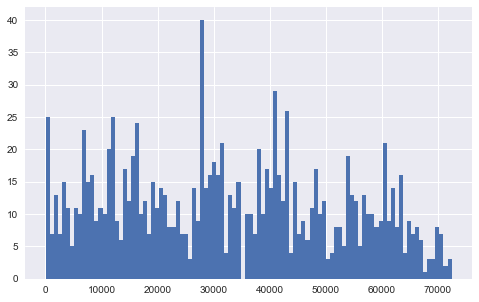

In [9]:
# Plot histogram of how many null values per row for the "housing_unit_median_gross_rent" feature. 
y = df[df['housing_unit_median_gross_rent'].isnull() == 1].housing_unit_median_gross_rent.index
x = range(1, len(y)+1)
plt.figure(figsize=(8, 5))
a = plt.hist(y, 100)

In [10]:
# Lets get to work, impute the daily solar radiation according to the mean per county
county_list = df.county.value_counts().index
county_list = county_list
for county in county_list:
    tmp = df[df['county' ] == county]
    a = tmp['daily_solar_radiation'].fillna( tmp['daily_solar_radiation'].mean())
    df.loc[a.index, 'daily_solar_radiation'] = a.values

# If the mean was also a NaN (Can happen if county has only one entry without solar radiation data)
# We throw away the rows
print('Remaining NaN values is "daily_solar_radiation": %d' % (np.sum(df['daily_solar_radiation'].isnull() == 1)))

Remaining NaN values is "daily_solar_radiation": 16


Excellent. We imputed most of the "daily_solar_radiation" values according to county. For ease of work, we'll now get rid of the rest of the NaN values:

In [11]:
orig_num_rows = df.shape[0]
df = df.dropna()
new_num_rows = df.shape[0]
print('%2.2f%% (%d of %d) of rows removed due to NaN values.' % 
      ((orig_num_rows-new_num_rows)*100/orig_num_rows, (orig_num_rows-new_num_rows), orig_num_rows))

3.76% (2015 of 53529) of rows removed due to NaN values.


Previously, I noticed there were **Inf** values. Let's check if they're still here:

In [12]:
df.max()

tile_count                                          4468
tile_count_residential                              1795
total_panel_area_residential                     40380.1
solar_panel_area_divided_by_area                 15983.3
solar_panel_area_per_capita                      6.29976
solar_system_count_residential                      1404
solar_system_count_nonresidential                    397
number_of_solar_system_per_household            0.559701
number_of_years_of_education                      18.615
diversity                                       0.812441
average_household_income                          537130
county                                     Zapata County
employed                                           24075
gini_index                                        0.7955
land_area                                        9489.73
per_capita_income                                 213267
population                                         53812
population_density             

Nope. Excellent. As far as I can see, the data is ready for processing.

### Data understading
For answering the first question (Identifying factors related to the density of solar panel deployment in residential areas) we can now start checking correlations and relations between features. I'll start with an obvious one, the "daily_solar_radiation".

In [13]:
# We generate a new column which is the density of deployed solar systems (residential) per Thousands households
df['sol_density'] = (df['solar_system_count_residential'] / df['household_count']) * 1000

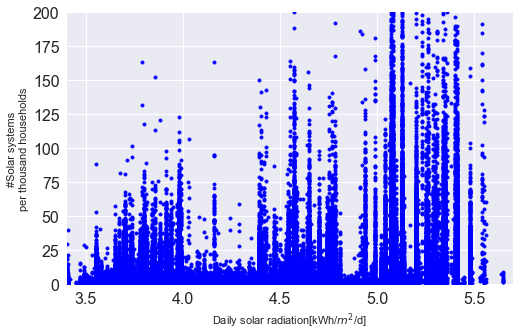

In [14]:
# Let's check the density vs. radiation
MyScatterPlot( df['daily_solar_radiation'], df['sol_density'], 
             'Daily solar radiation[kWh/$m^2$/d]', '#Solar systems\nper thousand households', [3.4, 5.7, 0, 200 ])

Umm.. Difficult to see the trend here. We would expect solar installations to increase in palces where there's a lot of sunlight.. I'll try to "quantize" the values of installed solar sytems to each "bin" of daily solar radiation. Then i'll use the mean of installed solar systems and I'll attempt to also plot a trend line. 

c:\apps\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


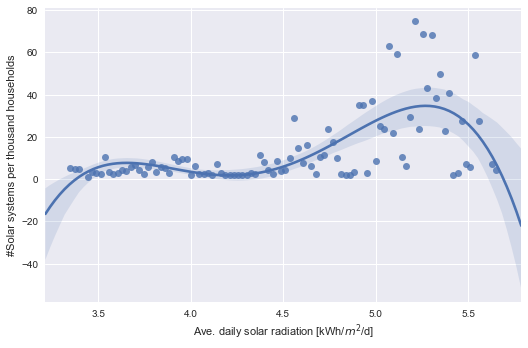

In [15]:
# We calc the average density per each level of daily solar radiation
n_grid_points = 100
x = np.linspace(df['daily_solar_radiation'].min(), df['daily_solar_radiation'].max(), n_grid_points)
y = CalcSolarDensityVsMeanOfColumn(df, 'daily_solar_radiation', x)

# Plot
d = {"Ave. daily solar radiation [kWh/$m^2$/d]": x, "#Solar systems per thousand households": y}
sns.set(font_scale = 1)
sns.lmplot(x = "Ave. daily solar radiation [kWh/$m^2$/d]", y = "#Solar systems per thousand households",
           data = pd.DataFrame(d), ci = 95, order = 4, aspect = 1.5)

#### 1st conclusion
Obviously, the more solar radiation we have the more the density of solar installation increases for residential areas. These results are similar to the ones the authors of the paper got. We see trend is Non-linear. 
The authors also identified 3 regions of solar radiation and performed their analysis conditioned on these levels:
1. Low solar radiation (< 4.5[Kwh/$m^2$/d])
2. Medium radiation (between 4.5 to 5[Kwh/$m^2$/d])
3. High radiation (> 4.5[Kwh/$m^2$/d])

This makes sense since there are different "trends" in each area. 
However, for **simplicity at cost of accuracy** I chose to "not copy" their work and find the trends with the data from all solar radiation levels together (for the residential areas).

Next I want to understand the relation between density of solar installation and the follwing parameters:
* Average income.
* Education years.
* Gini Index.
* population density.
* Simpson’s Diversity Index (racial). See: https://en.wikipedia.org/wiki/Diversity_index

c:\apps\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


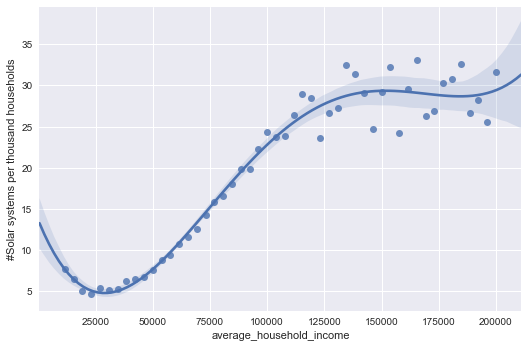

In [16]:
# Average income
# We calc the average density per each level of daily solar radiation
n_grid_points = 50
col_name = 'average_household_income'

x = np.linspace(df[col_name].min(), 200e3 ,n_grid_points)
y = CalcSolarDensityVsMeanOfColumn(df, col_name, x)

# Plot
d = {col_name: x, "#Solar systems per thousand households": y}
sns.set(font_scale = 1)
sns.lmplot(x = col_name, y = "#Solar systems per thousand households",
           data = pd.DataFrame(d), ci = 95, order = 4, aspect = 1.5)

c:\apps\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[10, 18, 0, 30]

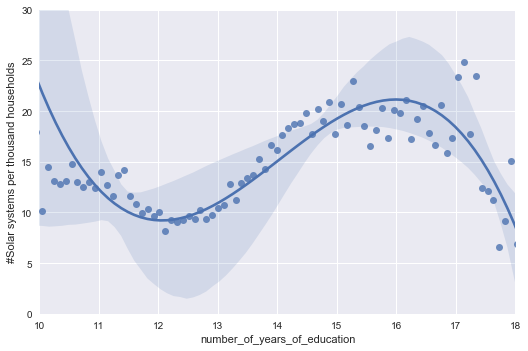

In [17]:
# Education years
n_grid_points = 100
col_name = 'number_of_years_of_education'

x = np.linspace(df[col_name].min(), df[col_name].max() ,n_grid_points)
y = CalcSolarDensityVsMeanOfColumn(df, col_name, x)

# Plot
d = {col_name: x, "#Solar systems per thousand households": y}
sns.set(font_scale = 1)
fgrid = sns.lmplot(x = col_name, y = "#Solar systems per thousand households",
                   data = pd.DataFrame(d), ci = 95, order = 3, aspect = 1.5)
ax = fgrid.axes[0][0]
ax.axis([10, 18, 0, 30])

c:\apps\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


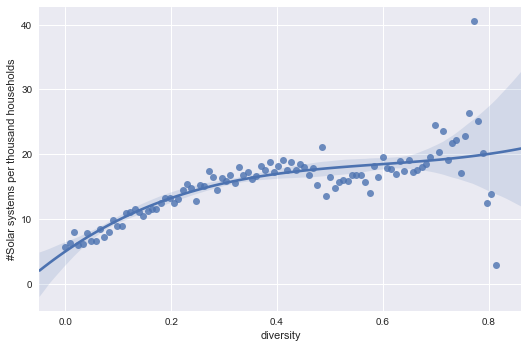

In [18]:
# Diversity index
n_grid_points = 100
col_name = 'diversity'

x = np.linspace(df[col_name].min(), df[col_name].max() ,n_grid_points)
y = CalcSolarDensityVsMeanOfColumn(df, col_name, x)

# Plot
d = {col_name: x, "#Solar systems per thousand households": y}
sns.set(font_scale = 1)
sns.lmplot(x = col_name, y = "#Solar systems per thousand households",
           data = pd.DataFrame(d), ci = 95, order = 3, aspect = 1.5)

# The more diverse the area the less solar installations. Index is probability that sampling of 2 people will have the same race. If low, means high diversity. If high, means low diversity. 
# This means that we need to further segment according to race to check who are installing the most.

[10, 100000.0, 0, 25]

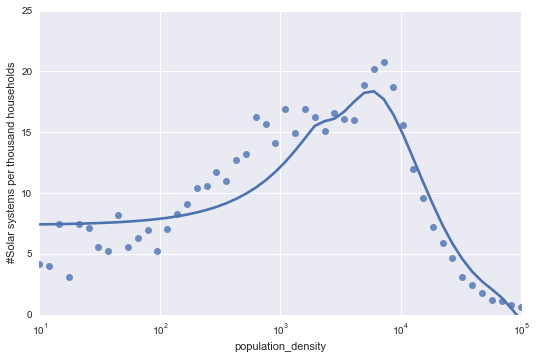

In [19]:
# Diversity index
n_grid_points = 50
col_name = 'population_density'

x = np.logspace(1,5 ,n_grid_points)
y = CalcSolarDensityVsMeanOfColumn(df, col_name, x)

# Plot
d = {col_name: x, "#Solar systems per thousand households": y}
fgrid = sns.lmplot(x = col_name, y = "#Solar systems per thousand households",
           data = pd.DataFrame(d), lowess = True, aspect = 1.5)
ax = fgrid.axes[0][0]
ax.set_xscale('log')
ax.axis([10, 1e5, 0, 25])


c:\apps\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


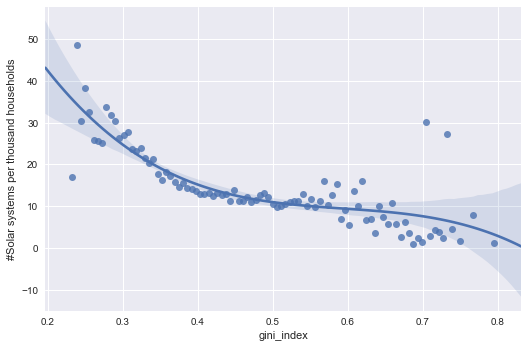

In [20]:
# Diversity index
n_grid_points = 100
col_name = 'gini_index'

x = np.linspace(df[col_name].min(), df[col_name].max(), n_grid_points)
y = CalcSolarDensityVsMeanOfColumn(df, col_name, x)

# Plot
d = {col_name: x, "#Solar systems per thousand households": y}
sns.set(font_scale = 1)
sns.lmplot(x = col_name, y = "#Solar systems per thousand households",
           data = pd.DataFrame(d), ci = 95, order = 3, aspect = 1.5)

### Socioeconomic factors impacting solar deployment
The figures above gave us some interesting insights regarding the solar deplyoment density. Specifically, each one of them indicates the following:
1. **Average household income:** density of deployment rises steadily until a peak annual income of about 150K. Beyond that the deployment density plateaus. 


2. **Average number of education years:** A bit tricky. The data indicates that people with 10-12 years of education (barely finished high school) deploy more solar panels than people with 13-14 years of education (college/mid university). I can think of reasons that this might happen (For example, usually people have either less than 12 years, 12 years or 16 years. If someone has 13-14 years it means he's probably a student and perhaps has lower income). 
**Bottom line - Up until 1st degree (16 years) number of deployments rise and beyond that drops**


3. **Diversity:** Reminder - The index tells us the probability that sampling 2 people with replacement from the population will have the same race, thus, small values indicate **high** diversity while large values indicate **small** diversity. We see that the solar deployment increases when diversity decreases. This raises additional questions: If so, are the levels of installation the same between different races? Perhaps Asians install more than white people? I didn't pursue these contiuation question due to time constraints. 

4. **Population density:** We see that solar deployment peaks at a density of $10^4[\dfrac{people}{(mile)^2}]$. This is probably because this an urban environment limit where people start living in building and not houses, thus, their available roof space for residential solar deployment decreases.

5. **Gini index:** We see a strong trend. The higher the inequality the lower the deployment density. 

Overall, these results indicate that if we eliminate physical reasons of not deploying solar panels (e.g. high population density), the deployment increases the higher the education and salary and decreases if large inequality exists. Further questions for research arise.


### ML part - prediction of residential panel area according to markers
Our data has many more columns I didn't explore, however, I can attempt to use them for prediction of panel area. 

In [24]:
# First, I want to drop from the dataset columns that might relate to the value I want to predict. (Such as number of solar systems, etc..)
# We want to predict: 'total_panel_area_residential'
columns_to_drop = ['tile_count', 'tile_count_residential', 'total_panel_area_residential',
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                   'solar_system_count_residential', 'solar_system_count_nonresidential',
                   'number_of_solar_system_per_household', 'county', 'state', 'sol_density']

X = df.drop( columns_to_drop, axis = 1 )
y = df['total_panel_area_residential']

# We now perform the random forest regression - no need for scaling of data
n_splits = 10
random_state = None
model, y_test_preds, y_test = RandomForestRegressorWithKFold(X, y, n_splits, random_state)

The R-squared score for the model was 0.54502 on 5152 values.
The R-squared score for the model was 0.60537 on 5152 values.
The R-squared score for the model was 0.57807 on 5152 values.
The R-squared score for the model was 0.61101 on 5152 values.
The R-squared score for the model was 0.63988 on 5151 values.
The R-squared score for the model was 0.58845 on 5151 values.
The R-squared score for the model was 0.63182 on 5151 values.
The R-squared score for the model was 0.62625 on 5151 values.
The R-squared score for the model was 0.65022 on 5151 values.
The R-squared score for the model was 0.54958 on 5151 values.
The average R-squared score is: 0.60257


### Results for predictions of panels area
A 10 fold validation was performed. (90% data for training, 10% for testing, each time, a different set of samples for data and training was taken). 
As can be seen, when attempting to predict the panels area, we get an **AVERAGE $R^2$ score around 0.6.** (Which mean we account for ~60% of the variablity in the solar panels area)

* The RF regressor I used was with default parameters, so more optimizations can be performed. 
* The "SolarForest (RF classifier + RF regressor)" estimator from the article achieves an $R^2$ of 0.722 (See table 1 in the [article]() ), thus, I'm not far behind.

What are the most important features for the predictions? In the next cells we can see them, but I got:

| Feature| Weight |
|--------|--------|
| daily_solar_radiation    | 0.2  |
| population | 0.13 |
| median_household_income | 0.1 |
| land_area    | 0.06 |
| occupancy_owner_rate | 0.03 |

These features alone explain more than 50% of the variablity. 

Even though the $R^2$ score seems reasonable, the bottom line is that this predictor isn't a very accurate one. 
In a later cell we can see the the quality of the estimator decreases for features that yield small densities of solar installations (and thus small areas for the solar panels). 
* This means that the MSE and the STD are even bigger than the value to be estimated itself. 
* For areas in a county with a lot of solar panel area, the error and standard deviations are smaller in proportion to the size we want to estimate. 


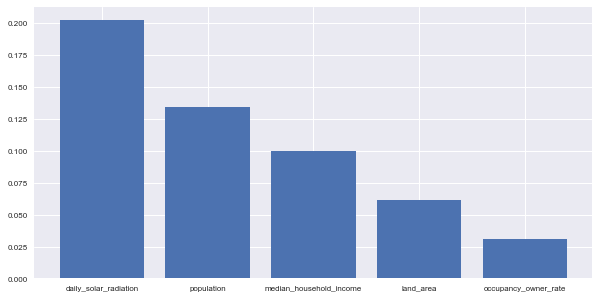

In [27]:
# Let's see the most 5 important features - we sort the feature importances from the RF
N = 5
FONT_SIZE = 8
idxs = np.argsort( model.feature_importances_ )
idxs = np.flip(idxs)[0:N]

# Plot
plt.figure(figsize=(10,5))
plt.bar( list(range(1,N+1)), model.feature_importances_[idxs], tick_label = X.columns[idxs].values )
plt.rc('font', size=FONT_SIZE)         
plt.rc('axes', labelsize=FONT_SIZE)    
plt.tick_params(labelsize=FONT_SIZE)

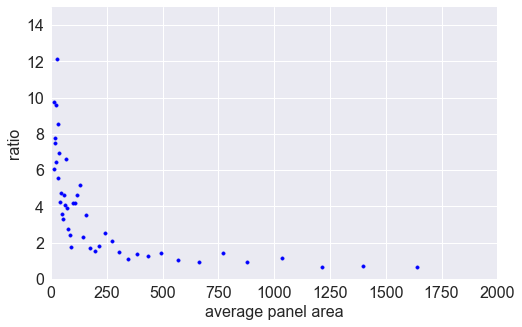

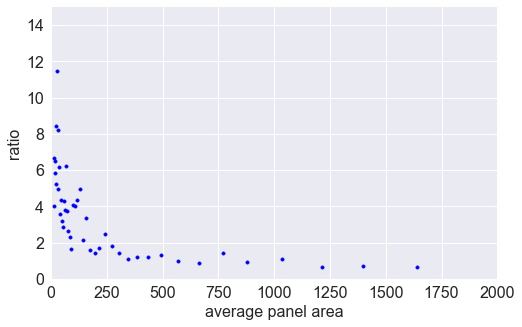

In [54]:
# Here I attempt to estimate the average error and its standard deviation. We see that the smaller the panel area the larger the 
mean_err_list = []
std_list = []
avg_panel_size_list_m2 = []
NS = range( 100, np.floor(len(y)/(n_splits+1)).astype(int), 100 )
num_of_rows_to_check = 100         # We want to check panel area results for 'num_of_rows_to_check' rows.

for ns in NS:
    N = ns + num_of_rows_to_check      # End index
    idxs = np.argsort( y_test ) # Sort the test panel area sizes
    err = y_test.iloc[idxs[ns:N]].values - y_test_preds[idxs[ns:N]] # Calculate the error
    mean_err = np.mean(np.square(err))  # Calculate the MSE (Mean Squared Error)
    std = np.std( err )                 # Calculate the standard deviation
    mean_err_list.append( mean_err )
    std_list.append( std )
    avg_panel_size_m2 = np.mean( y_test.iloc[idxs[ns:N]].values )
    avg_panel_size_list_m2.append( avg_panel_size_m2 )

# Ratio between panel area size to mean error in panel estimation size, and the ratio between the standard deviation to the panel area
MyScatterPlot( avg_panel_size_list_m2, np.sqrt(mean_err_list)/avg_panel_size_list_m2, 'average panel area', 'ratio', [0, 2e3, 0, 15])
MyScatterPlot( avg_panel_size_list_m2, np.divide( std_list, avg_panel_size_list_m2 ), 'average panel area', 'ratio', [0, 2e3, 0, 15])

### Can we use the solar panel data to boost the quality of inference of socio-economic parameters?
I attempt to answer that question via an example. I'll attempt to improve prediction the 'per_capita_income'. Why? We already saw that 'median_household_income' is an important feature for solar panel area prediction, so  this hints that the solar panel area data can help/
However, we can't really predict the income by panel area alone, so i'll use another parameter I believe to be highly correlated to income and it'll be the 'number_of_years_of_education'. I want to test if adding the solar panel AREA data helps the inference improve the $R^2$ metric. 

In [55]:
# We run twice. One time with the panel area information and one time without. 
n_splits = 10
random_state = None
columns_to_keep = [ ['total_panel_area_residential', 'solar_panel_area_divided_by_area','number_of_years_of_education'], 
                    ['number_of_years_of_education']]

for cols in columns_to_keep:
    print('Columns used for inference: %s' % (cols))
    X = df[cols]
    y = df['per_capita_income']
    RandomForestRegressorWithKFold(X, y, n_splits, random_state)

Columns used for inference: ['total_panel_area_residential', 'solar_panel_area_divided_by_area', 'number_of_years_of_education']
The R-squared score for the model was 0.63518 on 5152 values.
The R-squared score for the model was 0.67622 on 5152 values.
The R-squared score for the model was 0.67921 on 5152 values.
The R-squared score for the model was 0.66805 on 5152 values.
The R-squared score for the model was 0.69074 on 5151 values.
The R-squared score for the model was 0.66793 on 5151 values.
The R-squared score for the model was 0.69063 on 5151 values.
The R-squared score for the model was 0.64144 on 5151 values.
The R-squared score for the model was 0.66556 on 5151 values.
The R-squared score for the model was 0.67330 on 5151 values.
The average R-squared score is: 0.66883
Columns used for inference: ['number_of_years_of_education']
The R-squared score for the model was 0.53793 on 5152 values.
The R-squared score for the model was 0.57538 on 5152 values.
The R-squared score for th

**Success!** Our prediction of income has improved (0.1 improvement in the $R^2$ score). This hints to the fact that even just the raw solar panel data of panels area can improve predictions of socio-economic parameters. 
Which parameters, how much improvement, etc. is yet to be studied, but I hope that for the scope of the Udacity exercise (and especially since this data wasn't even of of the suggested datasets) it's enough. 